# Implementing the SIR Model
Ravi Dayabhai

Note: This notebook is purely for my own edification!

**Sources**: 

- [Compartmental models in epidemiology](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#Bio-mathematical_deterministic_treatment_of_the_SIR_model), Wikipedia

- [Mathematical modelling and prediction in infectious disease epidemiology](https://www.sciencedirect.com/science/article/pii/S1198743X14630019#cesec20), A. Huppert, G. Katrielb in  _Clinical Microbiology and Infection_ (Volume 19, Issue 11, November 2013, PP. 999-1005)

In [1]:
from itertools import product
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
%matplotlib inline 

## Introduction 

The intuition behind the SIR model is relatively straightforward; it's really just a fancy application of related rates type problems (e.g., filling a bath tub as it drains) from high school calculus.

![Susceptible-Infective-Recovered Model](http://math.ucr.edu/home/baez/networks/SIR.png)

Putting aside the definitions above, the mechanics of the model bring to light some interesting considerations that I don't think I quite appreciated (and more that highlight how gnarly it is to grapple with the evident shortcomings).

### Mathematical model

In this model, a population is divided into *susceptible*, *infective*, and *recovered* individuals, with the functions $S(t)$, $I(t)$ and $R(t)$ denoting their respective fractions in the populations at time $t$ (measured, for example, in days). The evolution of these quantities is described by the differential equations:

$$
\begin{align}
\frac{dS}{dt} &=&  -\beta I(t) S(t) \\
\frac{dI}{dt} &=&  \beta I(t) S(t) - \gamma I(t) \\
\frac{dR}{dt} &=&  \gamma I(t)
\end{align}
$$


- The derivatives $\frac{dS}{dt}$, $\frac{dI}{dt}$, and $\frac{dR}{dt}$ measure the rates of change of the quantities $S(t)$, $I(t)$, and $R(t)$. 

- The transmission parameter $\beta$ is the average number of individuals that one infected individual will infect per time unit, assuming that all contacts that this individual makes are with susceptible individuals. Thus, a more highly infectious disease has a higher $\beta$. 

- The number $\gamma$ is the rate of recovery, so that $\frac{1}{\gamma}$ is the average time period during which an infected individual remains infectious. 

- The product $\beta I(t) S(t)$ is the total infection rate, the fraction of the population that will be infected per unit time at time t. To understand this, note that, if a fraction $I(t)$ of the population is currently infected, then they would infect a fraction $\beta I(t)$ of the population per unit time if all of their contacts were with susceptible individuals, but as only a fraction $S(t)$ of the population is currently susceptible, they will only infect $\beta I(t) S(t)$ per unit time.

### Deriving $R_0$

The ratio $\frac{\beta}{\gamma}$ is also known as the basic reproductive number $R_0$, which is an important index for quantifying the transmission of pathogens. $R_0$ is defined as the average number of people infected by an infected individual over the disease infectivity period, in a totally susceptible population.

This simple model, which is the basis for many elaborations, turns out to provide some quite striking predictions. By entering the above differential equations into any software for the numerical solution of differential equations, and choosing some values for $\beta$ and $\gamma$ together with the initial values (normalized by $N$, the total population) $S(0)$, $I(0)$, and $R(0)$, it is possible to generate an epidemic curve corresponding to this model, that is a prediction for the fraction of the population that will be infected on each day of the epidemic. Moreover, analytical tools allow us to draw some general conclusions about the model's solutions. The most important conclusions are as follows:

1. The epidemic threshold: if the inequality $S(0) \cdot R_0 < 1$ holds, then the number of infected individuals will rapidly decrease; that is, no epidemic will occur. Note that, if $S(0) \cdot R_0 > 1$, then an epidemic will occur, no matter how small the initial number of infected individuals.


2. The size of the epidemic, when it occurs, will not depend on the initial number of infectives, but it will depend on the initial fraction of susceptibles, $S(0)$, and on $R_0$. An important point here is that the final size of the epidemic (the fraction of the population infected) will always be strictly smaller than the initial fraction of the population that was susceptible, $S(0)$, so that there will always remain a subpopulation of susceptible individuals who have not been infected.


These conclusions, in so far as they apply in reality, have some crucial implications. Most notably, the epidemic threshold implies that, if we vaccinate a fraction of the population prior to the arrival of the pathogen, so as to reduce the initial fraction of susceptibles to $S(0) < \frac{\gamma}{\beta}$, then we will have prevented an epidemic. This result underlies the concept of herd immunity, whereby prevention of an epidemic can be achieved if a sufficiently large fraction of the population is vaccinated. If we do not achieve sufficiently high vaccination coverage, then we will have only reduced the size of the epidemic, and not have prevented it. Other ways to achieve the condition $S(0) < \frac{\gamma}{\beta}$, and thus to eliminate an epidemic are:

1. reducing the transmissibility parameter $\beta$ by isolation of infectives or social distancing measures; and
2. increasing the recovery rate $\gamma$ by treatment of infectives.

### Set Initial Conditions

In [2]:
# Total population, N
N = 300e6

# Initial number of infected and recovered individuals, I0 and R0
I0, R0 = 1e6, 1000

# Everyone else, S0, is susceptible to infection initially
S0 = N - I0 - R0

# A grid of time points (in days)
days = 180
t = np.linspace(0, days, days)

# The SIR model differential equations
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0

### Define Functions

The following functions will help us generate the calculations and plots for various scenarios.

In [3]:
def solver(R_naught, gamma):
    # Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
    beta = R_naught * gamma
    
    # Integrate the SIR equations over the time grid, t
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T
    
    return S, I, R

In [8]:
def plot_SIR_curves(scenario_pairs):

    # Getting scenario parameters
    unique_R_naughts = list(set([pair[0] for pair in scenario_pairs]))
    unique_gammas = list(set([pair[1] for pair in scenario_pairs]))
    
    # Setting up plot
    fig, axes = plt.subplots(nrows=len(unique_R_naughts), 
                         ncols=len(unique_gammas), 
                         sharex=False, sharey=True, 
                         figsize=(12, 13), facecolor='w')
    
    title_text = "Scenarios: Varying $R_0$ & $\gamma$"    
    fig.suptitle(title_text, fontsize=14)

    # Labeling rows and columns
    rows_labels = [f"$R_0$ = {R_naught:.2f}" for R_naught in unique_R_naughts]
    for ax, row_label in zip(axes[:,0], rows_labels):
        ax.set_ylabel(row_label, rotation=90, size='x-large', labelpad=30)    

    cols_labels = [f"$T_r$ = {1/gamma:.0f} days" for gamma in unique_gammas]
    for ax, col_label in zip(axes[0], cols_labels):
        ax.set_title(col_label, size='x-large', pad=13)
    
    # Iterating through each subplot
    for i in range(len(unique_R_naughts)):
        for j in range(len(unique_gammas)):
            
            R_naught = unique_R_naughts[i]
            gamma = unique_gammas[j]
            
            # Plotting data on subplots
            S, I, R = solver(R_naught, gamma)

            axes[i][j].plot(t, S/1e6, 'b', alpha=0.5, lw=2, label='Susceptible')
            axes[i][j].plot(t, I/1e6, 'r', alpha=0.5, lw=4, label='Infected')
            axes[i][j].plot(t, R/1e6, 'g', alpha=0.8, lw=2, label='Recovered (with immunity) or Died')
            
            # Formatting subplots
            axes[i][j].yaxis.set_tick_params(length=0)
            axes[i][j].xaxis.set_tick_params(length=0)
            axes[i][j].grid(b=True, which='both', c='grey', lw=2, ls='-', alpha=0.1)

            for spine in ('top', 'right'):
                axes[i][j].spines[spine].set_visible(False)
                
            # Labeling the edge axes
            if j == 0:
                axes[i][j].text(-50, 100, r'People (MMs.)', fontsize=10, rotation=90)
                
            if i == 2:
                axes[i][j].set_xlabel("Time (days)")
         
        # Creating inputs custom figure legend
        line_handles, line_labels = axes[i][j].get_legend_handles_labels()
    
    # Creating custom figure legend
    fig.legend(handles=line_handles, labels=line_labels, 
               borderaxespad=0.1, ncol=3, 
               loc="upper center", bbox_to_anchor=(0.5,.95), 
               bbox_transform=plt.gcf().transFigure)

    plt.show()

## Scenarios

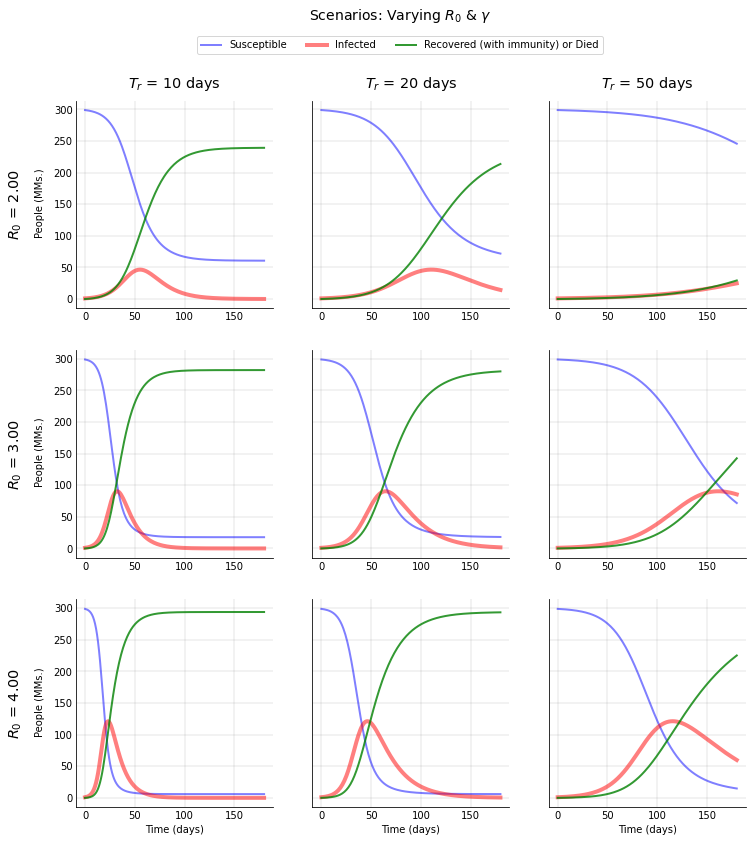

In [9]:
# Construct scenarios
R_naught_list = [2, 3, 4]
gamma_list = [1/10, 1/20, 1/50]

scenario_pairs = list(product(R_naught_list, gamma_list))

# Plot scenarios
plot_SIR_curves(scenario_pairs)

### Should the predictions from this very simple model be trusted in policy-making?

Let us first note some reasons for skepticism. There are many assumptions implicit in the SIR models that are not realistic, for example:

• **Well-mixed population** — the derivation of the term $\beta S(t) I(t)$ in the equations assumes that each individual is equally likely to come into contact with any other individual in the population. This ignores the fact that contacts are much more likely between individuals who are geographically and socially closer.

• **Homogeneity of the population** — the model does not allow for the fact that individuals may be different from each other in ways that are relevant to the transmission of infection. There are individuals who are more susceptible to infection or more infectious than others; and there are individuals who make more contacts than others.

• **Exponentially distributed duration of infection** — this refers to the fact that the model assumes both that a person becomes infectious immediately upon being infected, and that the probability of recovery per unit time does not depend on the time that has passed since infection. Both assumptions are unrealistic.

• **Large population** — the very form of the model, formulated in terms of continuous quantities (fractions of the population), implicitly assumes that the population is large (strictly speaking, infinite). In a small population (e.g. a village or school), stochastic effects are much more important, and modelling using mean field approximations (i.e. by differential equations) becomes problematic.

## Thoughts

_Sophomoric Knowledge at its Finest_

### Purpose of this exercise

**First and foremost**, from inception, this model has been, currently is, and will continue to be flat out wrong. This wrongly treats the US as a well-mixed, massively populated system with a million initial cases (lack of testing is preventing us from actually knowing). 

That's all to say...it doesn't mean we can't learn anything at all! 

**Motivations**:

1. I was very, very wrong about COVID-19. I know virtually nothing about disease modeling, very little about differential equations, and without a doubt, zilch about virus epidemiology. I was curious how our current public health phenomenon could be simply characterized by and individual exhibiting these characteristics.

2. This is good practice for me on the data analysis front, especially using the tools available in the Python data stack.

3. My friends Ravi Umarji ("Ravi 1") and Renee Wurth ("George W. Bush") estimate that the current lock-down conditions in SF (and elsewhere around the world) due to COVID-19 could last 8+ months or more. I was curious what this duration might imply in a simple disease transmission model such as the SIR model.

Which reminds me, there is an important precondition to all of this:

4. I'm stuck at home.

### Takeaways

#### 1

- All of this is moot if a recovered SaRs-COV-2 patient does not properly develop antibodies to prevent reinfection or is still infectious post-recovery. 

**TL;DR**: This doesn't appear to be a concern [right now](https://www.nytimes.com/2020/02/29/health/coronavirus-reinfection.html).


#### 2

- This dynamic system is really had to wrap your head around given any perturbation of the input variables. SIR assumes constant contact rate ($\beta$) and ($\gamma$, or it's inverse, the time to recovery $T_r$), but it's pretty easy to see that these are far from constant through time.

$\beta$ and $\gamma$ will not to be constant as $t \rightarrow +\infty$. We recognize how essential it is to "flatten the curve" through social distancing ($\downarrow \beta \implies \downarrow R_0$, c.p.), but what I failed to appreciate was how a blow-out to the healthcare system (which cognitively we know is bad) effectively $\downarrow \gamma$ which takes what would be a short, intense peak and extends it over a _long_ time. That'd pretty catastrophic if that were a static change -- but longer recovery times would probably lead to only longer recovery times: a calamitous upregulating phenomena.

**TL;DR**: We need to treat those that are sick _quickly_ (in addition to isolating them) so we have a stock of (newly) healthy and virus-resistant people to put back into the population when social restrictions are lifted to prevent a "second spike".


#### 3

- The feedback loop of \[a large number of\] people infected reducing the number of healthy people that _could_ be infected impacts the overall rate of infection through time, which naturally limits the diseases transmittance. 

This point seems like an obvious one (i.e., infection rates will fall as more people get sick; [true growth is logistic, not exponential](https://youtu.be/Kas0tIxDvrg?t=246)), but its profundity was generally lost on me as we, as a consensus, have been frightened by the disease's incredible contagiousness. At least by what the media reports, this fact is often overlooked (and rightfully so -- it's easy to get complacent and trust in people's immune systems to en masse beat COVID-19) independent of measures taken (e.g., social distancing of the general population) to reduce $R_0$.

What this means is that, yes, we could shorten the duration of the disease if we either let people contract or fail to prevent people from contracting the affliction. Simply put, this would be "letting it run its course" almost unabated. I'm not advocating for this strategy since the width of the up-down of the red hump over the x-axis fails to account for the tremendous cost in terms of dollars and lives.

**TL;DR**: Infection rates will fall as a consequence of $\downarrow \beta$ as susceptible population declines independent of coordinated proactive measures -- but it would entirely stupid to rely on this alone.

#### 4

- Partitioning the population would do a lot to break the first assumption of the model (heterogenous mixing) and accelerate local (in the geographic sense) disease eradication.

We are pretty naturally partitioned (along demographic, geographic, socioeconomic, etc.) lines, which will make the starkness of the above plots a little overexaggerated. 

#### 5

- Because $\uparrow \beta$ actually _lowers_ epidemic duration (think: shorter, more intense epidemic where Point #3 kicks in faster), we are caught trying to do two things across two time horizons based on decisions we have to make at one time (read: now). But we we face cost constraints.

Warning: this part is pretty reductionist and not fully-baked.

Ideally, we could minimize both (i) economic disruption and (ii) public health risk across both (A) the short term and (B) the long term. Unfortunately, given our constraints (read: what we can do), there is bit of a dilemma. In order to minimize (ii) for both (A) & (B), we have to let (i) go in (A) and hope that (i) isn't impacted in (B). Alternatively, we could punt on (ii), triage as best we can, in order to shorten the duration, pick up the pieces and preserve (i) if panic didn't tear us to shreds.

...and of course none of this really fully captures the our true contraints (e.g., developing treatments, etc.) or the interplay between (i) and (ii) through time (A), (B). Honestly, I'm _still_ having a tough time framing this into something coherent.

<img src="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3935673/bin/AJPH.2013.301704f4.jpg"></img>

<p style="text-align: center"><i>See the chart on the left (for the SIR model). I wish I had found this sooner...would've saved me from writing this notebook.</i></p>

More to come as I give this more thought...